In [ ]:
import kagglehub
ducnguyen168_dataset_skin_tone_path = kagglehub.dataset_download('ducnguyen168/dataset-skin-tone')

print('Data source import complete.')


100%|██████████| 942M/942M [00:11<00:00, 85.2MB/s]

Extracting files...


Data source import complete.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data

In [5]:
import os
import torch
from torchvision import transforms, datasets

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
#     'test': transforms.Compose([
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
}

data_dir = '/root/.cache/kagglehub/datasets/ducnguyen168/dataset-skin-tone/versions/1/data_skintone'

# Load all data
all_data = datasets.ImageFolder(data_dir, data_transforms['train'])

# Calculate the size of train, val, test datasets
total_size = len(all_data)
train_size = int(0.8 * total_size)
val_size = (total_size - train_size)


# Split the data
train_data, val_data = torch.utils.data.random_split(
    all_data, [train_size, val_size])

# Create dataloaders
dataloaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4),
}

dataset_sizes = {
    'train': len(train_data),
    'val': len(val_data),
}

class_names = all_data.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)
print(device)
print(dataset_sizes)

FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/ducnguyen168/dataset-skin-tone/versions/1/data_skintone'

In [ ]:
!mkdir output

In [ ]:
import matplotlib.pyplot as plt
import os

def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join("output", 'best_model_paramsfore32.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        # Lists to store training history
        train_loss_history = []
        train_acc_history = []
        val_loss_history = []
        val_acc_history = []

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Save history for plotting
                if phase == 'train':
                    train_loss_history.append(epoch_loss)
                    train_acc_history.append(epoch_acc)
                else:
                    val_loss_history.append(epoch_loss)
                    val_acc_history.append(epoch_acc)

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_loss = epoch_loss
                    torch.save(model.state_dict(), best_model_params_path)
            if epoch % 10 == 0:
              last_model_params_path = os.path.join("output", f'last_model_params_epoh_{epoch}fo32g.pt')
              torch.save(model.state_dict(), last_model_params_path)
            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
        print(f'Best val Loss: {best_acc:4f}')

        # Load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

        # Plot training history
        plot_training_history(train_loss_history, val_loss_history, train_acc_history, val_acc_history, "output")

    return model

def plot_training_history(train_loss, val_loss, train_acc, val_acc, output_dir):
    train_loss_cpu = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in train_loss]
    val_loss_cpu = [loss.item() if isinstance(loss, torch.Tensor) else loss for loss in val_loss]
    train_acc_cpu = [acc.item() if isinstance(acc, torch.Tensor) else acc for acc in train_acc]
    val_acc_cpu = [acc.item() if isinstance(acc, torch.Tensor) else acc for acc in val_acc]

    # Vẽ biểu đồ Loss và Accuracy
    def plot(title, ylabel, train_data, val_data, filename):
        plt.figure(figsize=(10, 5))
        plt.plot(train_data, label='Training')
        plt.plot(val_data, label='Validation')
        plt.title(title)
        plt.xlabel('Epoch')
        plt.ylabel(ylabel)
        plt.legend()
        plt.savefig(os.path.join(output_dir, filename))
        plt.show()

    # Vẽ biểu đồ Loss
    plot('Training and Validation Loss', 'Loss', train_loss_cpu, val_loss_cpu, 'loss_plot150Mobilel32.png')

    # Vẽ biểu đồ Accuracy
    plot('Training and Validation Accuracy', 'Accuracy', train_acc_cpu, val_acc_cpu, 'accuracy_plot150Mobilel32.png')

Training the model

Finetuning the ConvNet

Model Resnet

In [ ]:
# model_ft = torchvision.models.resnet152(pretrained = True)

# # # Parameters of newly constructed modules have requires_grad=True by default
# num_ftrs = model_ft.fc.in_features


# model_ft.fc = nn.Sequential(
#     nn.Dropout(0.85),
#     nn.Linear(num_ftrs, 512),
#     nn.Dropout(0.7),
#     nn.Linear(512, 128),
#     nn.Dropout(0.7),
#     nn.Linear(128, 4)

# )
# # model_ft.fc = nn.Linear(num_ftrs, 3)

# model_ft = nn.DataParallel(model_ft)
# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()

# # Quan sát rằng tất cả các tham số đang được tối ưu hóa
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# # optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Model Mobilenet

In [ ]:
model_ft = models.mobilenet_v2(pretrained=True)

num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(num_ftrs, 50),
    nn.Dropout(0.5),
    nn.Linear(50, 4)
)
# model_ft.classification = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/4
----------
train Loss: 0.5846 Acc: 0.7588
val Loss: 0.3925 Acc: 0.8324

Epoch 1/4
----------
train Loss: 0.4050 Acc: 0.8342
val Loss: 0.3064 Acc: 0.8642

Epoch 2/4
----------
train Loss: 0.3380 Acc: 0.8578
val Loss: 0.3361 Acc: 0.8725

Epoch 3/4
----------
train Loss: 0.3097 Acc: 0.8689
val Loss: 0.2589 Acc: 0.8863

Epoch 4/4
----------
train Loss: 0.2922 Acc: 0.8776
val Loss: 0.2686 Acc: 0.8824

Training complete in 440m 32s
Best val Acc: 0.886268
Best val Loss: 0.886268


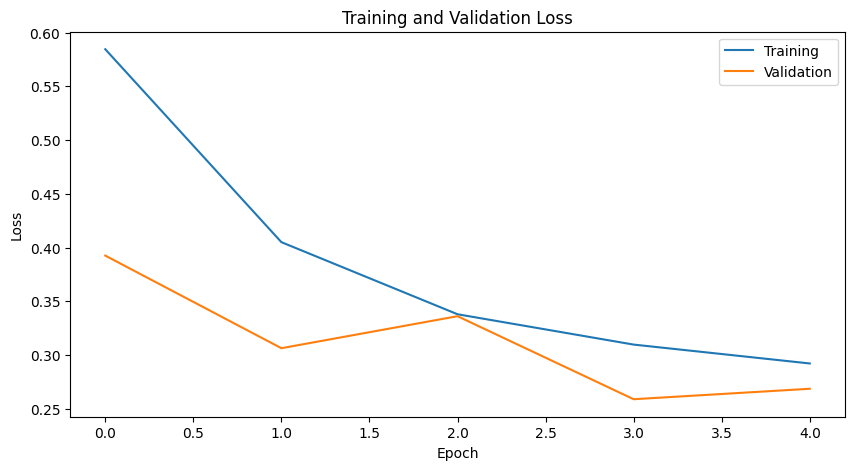

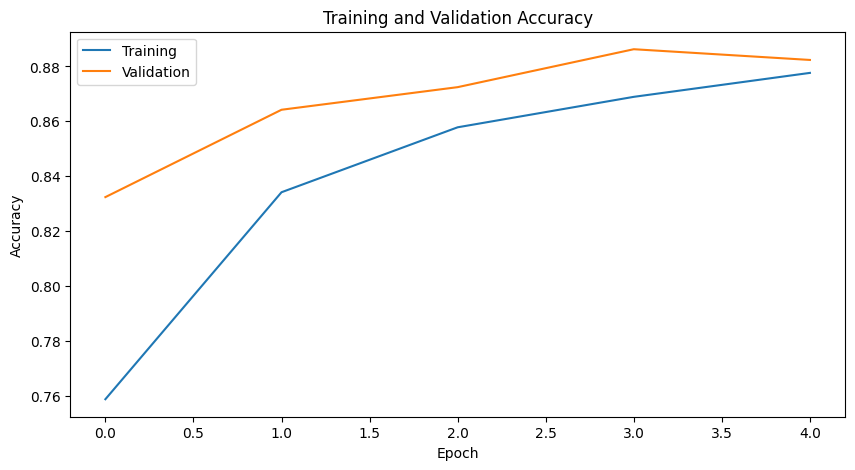

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

In [ ]:
def visualize_model(model, test_folder):
    was_training = model.training
    model.eval()
    label = []
    prediction = []

    for path in os.listdir(test_folder):
        level = os.path.join(test_folder, path)
        for img in os.listdir(level):
            label.append(path)
            img_path = os.path.join(level, img)
            img = Image.open(img_path)
            img = data_transforms['val'](img)
            img = img.unsqueeze(0)
            img = img.to(device)

            with torch.no_grad():
                outputs = model(img)
                _, preds = torch.max(outputs, 1)
                prediction.append(class_names[preds[0]])

    count = sum(label[i] == prediction[i] for i in range(len(label)))
    accuracy = count / len(label)
    print(f'Accuracy on test set: {accuracy}')

# # Load model from the best checkpoint
model_ft.load_state_dict(torch.load("/content/output/best_model_paramsfore32.pt", map_location=torch.device('cpu')))
model_ft.to(device)

# Visualize the model accuracy on the test set
visualize_model(model_ft, '/content/AllSmile1000/test')

FileNotFoundError: [Errno 2] No such file or directory: '/content/AllSmile1000/test'

Predict

In [ ]:

# Test on a single image
image_path = '/root/.cache/kagglehub/datasets/ducnguyen168/dataset-skin-tone/versions/1/data_skintone/light/100016175.jpg'
image = Image.open(image_path)

# Apply the same transformations as the validation set
transform = data_transforms['val']
image = transform(image).unsqueeze(0) # Add batch dimension

# Move the image to the same device as the model
image = image.to(device)

# Set the model to evaluation mode
model_ft.eval()

# Make a prediction
with torch.no_grad():
    outputs = model_ft(image)
    _, predicted_class_index = torch.max(outputs, 1)

# Get the class name
predicted_class_name = class_names[predicted_class_index.item()]

print(f'The predicted skin tone for the image {image_path} is: {predicted_class_name}')

The predicted skin tone for the image /root/.cache/kagglehub/datasets/ducnguyen168/dataset-skin-tone/versions/1/data_skintone/light/100016175.jpg is: mid-light


In [ ]:
# prompt: download pt best model to pc

from google.colab import files

files.download("/content/output/best_model_paramsfore32.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>